In [207]:
# Helpers
from collections import Counter, defaultdict
import numpy as np
from itertools import chain
import pickle

#DB
from django.db.models import Case, IntegerField, Value

# Plot
import matplotlib.pyplot as plt

In [202]:
folder = "data/edm2020/"

### Creating train and test sets
We have Q-Matrix for the first 54 solutions that were validated by the professors. So, we can only use that students that replied to these problems in the dataset.

#### Descriptive statistics

In [172]:
# Filter used problems and solutions
last_id = 132
problems = Problem.objects.filter(id__lte=last_id)
solutions = Solution.objects.filter(problem__in=problems, ignore=False).values_list('problem', flat=True)
problems = solutions.order_by('problem').values_list(
    'problem', flat=True).distinct('problem')
print("Total number of questions: %d" % problems.count())
print("Total number of solutions: %d" % solutions.count())

print("%d problems with 1 solution" % Counter(Counter(solutions).values())[1])
print("%d problems with 2 solutions" % Counter(Counter(solutions).values())[2])

Total number of questions: 48
Total number of solutions: 54
42 problems with 1 solution
6 problems with 2 solutions


Mean number of evaluations: 4.04
Max number of evaluations: 5
Min number of evaluations: 3


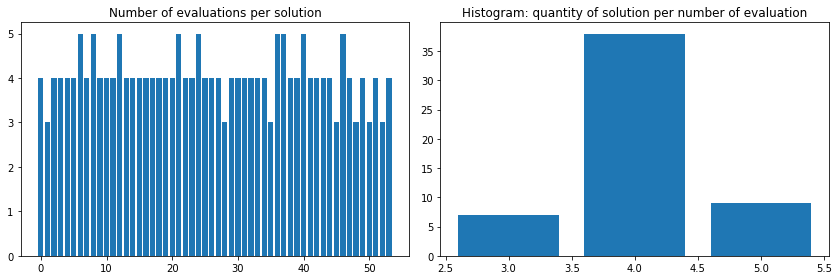

In [137]:
# Get voted concepts per solution
concepts = SolutionConcept.objects.all()
count = concepts.values_list('solution').annotate(count=Count('user', distinct=True))
sol_id, eval_count = zip(*list(count))
# plt.figure(figsize=(10,8))

print("Mean number of evaluations: %.2f" % np.mean(eval_count))
print("Max number of evaluations: %d" % np.max(eval_count))
print("Min number of evaluations: %d" % np.min(eval_count))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
ax1.bar(range(len(sol_id)), eval_count)
ax1.set_title("Number of evaluations per solution")
ax2.bar(Counter(eval_count).keys(), Counter(eval_count).values())
ax2.set_title("Histogram: quantity of solution per number of evaluation")
plt.tight_layout()
plt.show()

Mean number of evaluations: 4.42
Max number of evaluations: 8
Min number of evaluations: 3


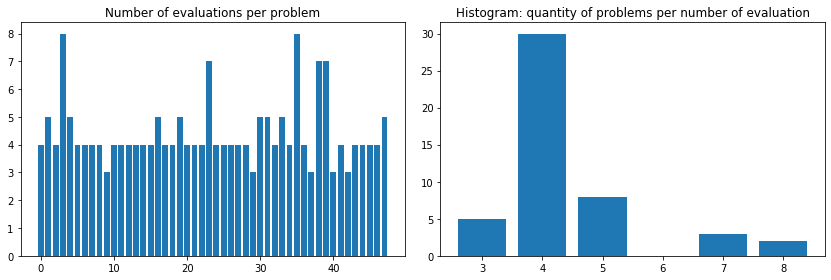

In [136]:
# Get voted concepts per problem
concepts = SolutionConcept.objects.all()
count = concepts.values_list('solution__problem').annotate(count=Count('user', distinct=True))
sol_id, eval_count = zip(*list(count))
# plt.figure(figsize=(10,8))

print("Mean number of evaluations: %.2f" % np.mean(eval_count))
print("Max number of evaluations: %d" % np.max(eval_count))
print("Min number of evaluations: %d" % np.min(eval_count))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
ax1.bar(range(len(sol_id)), eval_count)
ax1.set_title("Number of evaluations per problem")
ax2.bar(Counter(eval_count).keys(), Counter(eval_count).values())
ax2.set_title("Histogram: quantity of problems per number of evaluation")
plt.tight_layout()
plt.show()

#### Concept agreement

Total number of valid concepts: 14
1 - Syntax
2 - Assignment
3 - Data type: number
4 - Data type: boolean
5 - Math
6 - Logic
7 - Data type: string
8 - Data type: list (or array)
9 - Data type: tuple
10 - Data type: dict
11 - Conditional
12 - Loop
13 - Nested loop
14 - Function

Most used concept(s): 'Loop' present in 25 problems.
Least used concept(s): 'Assignment; Data type: boolean' present in 1 problem(s).

One concept is present in average in 11.00 problems.
One problem has an average of 3.21 concepts.


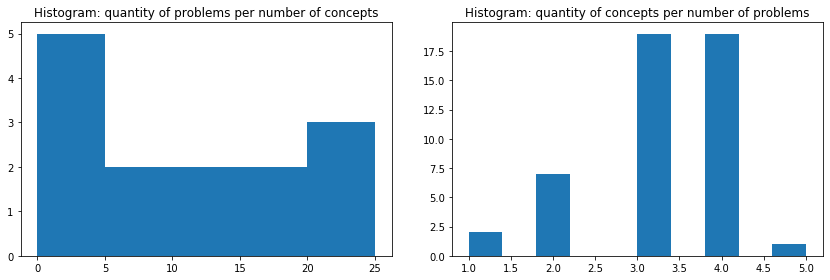

In [171]:
# Count concept agreement per problem
count_per_problem = dict(concepts.values_list('solution__problem').annotate(
    count=Count('user', distinct=True)))

MIN_THRESHOLD = 0.5
agreed_concepts = defaultdict(list)
agreed_concepts_len = {}

# Filter out the concepts that didn't have agreement (50% of evaluators voted for it)
for problem in problems:
    max_votes = count_per_problem[problem]
    concepts_per_problem = dict(concepts.filter(solution__problem=problem).values_list('concept').annotate(
        count=Count("concept")))
    for concept, value in concepts_per_problem.items():
        if value >= (max_votes * MIN_THRESHOLD):
            agreed_concepts[problem].append(concept)
    agreed_concepts_len[problem] = len(agreed_concepts[problem])
            
agreed_concepts_all = list(chain.from_iterable(agreed_concepts.values()))
agreed_concepts_set = set(agreed_concepts_all)
print("Total number of valid concepts: %d" % len(agreed_concepts_set))
for concept in agreed_concepts_set:
    print(Concept.objects.get(pk=concept))

# Get most used concept
concepts_counter = Counter(agreed_concepts_all)
most_common = concepts_counter.most_common()[0]
count_most_common  = list(concepts_counter.values()).count(most_common[1])
most_common = concepts_counter.most_common()[:count_most_common]
most_concepts, values = zip(*most_common)
most_concepts = '; '.join(list(Concept.objects.filter(
    pk__in=most_concepts).values_list('label', flat=True)))

# Get least used concept
least_common = concepts_counter.most_common()[-1]
count_least_common  = list(concepts_counter.values()).count(least_common[1])
least_common = concepts_counter.most_common()[-count_least_common:]
least_concepts, values = zip(*least_common)
least_concepts = '; '.join(list(Concept.objects.filter(
    pk__in=least_concepts).values_list('label', flat=True)))


print()
print("Most used concept(s): '%s' present in %d problems." % (most_concepts, most_common[0][1]))
print("Least used concept(s): '%s' present in %d problem(s)." % (least_concepts, least_common[-1][1]))
print()
print("One concept is present in average in %.2f problems." % np.mean(list(concepts_counter.values())))
print("One problem has an average of %.2f concepts." % (np.mean(list(agreed_concepts_len.values()))))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
ax1.hist(concepts_counter.values(), bins=range(0,30,5))
ax1.set_title("Histogram: quantity of problems per number of concepts")
ax2.hist(agreed_concepts_len.values())
ax2.set_title("Histogram: quantity of concepts per number of problems")
plt.tight_layout()
plt.show()

### Build Q-Matrix
Total number of concepts: 14

Total number of problems: 48

In [198]:
concept_idx = np.asarray(list(agreed_concepts_set))
questions_idx = list(problems)

q_matrix = np.zeros((len(concept_idx), len(questions_idx)))

for q_idx, question_id in enumerate(questions_idx):
    used_concepts = agreed_concepts[question_id]
    q_matrix[np.where(np.isin(concept_idx, used_concepts)), q_idx] = 1

In [204]:
with open("%s/q_matrix.pkl" % folder, "wb") as pklfile:
    pickle.dump(q_matrix, pklfile)

### Create train and test sets

In [227]:
# Get all students
user_blacklist = UserProfile.objects.filter(professor__user__username='sem_professor')

attempts = UserLog.objects.exclude(outcome='S').filter(
    timestamp__lt=OuterRef('timestamp'), user__id=OuterRef('user__id')).annotate(
    attempt=Count('*')).values('attempt')

# Remove group by values
attempts.query.set_group_by()

# Get users
users = UserLog.objects.filter(problem__in=problems).exclude(outcome='S').exclude(
    user__userprofile__in=user_blacklist).annotate(
    attempt=Subquery(attempts, output_field=IntegerField())).annotate(
    score=Case(
        When(outcome='F', then=Value(0.1)),
        When(outcome='P', then=Value(1)),
        output_field=IntegerField())).values_list(
    "user__id", "problem_id", "attempt", "score"#"outcome", "timestamp"
).order_by("timestamp").filter(attempt=1).values_list('user_id', flat=True)

data = UserLog.objects.filter(problem__in=problems).exclude(outcome='S').annotate(
    attempt=Subquery(attempts, output_field=IntegerField())).annotate(
    score=Case(
        When(outcome='F', then=Value(0.1)),
        When(outcome='P', then=Value(1)),
        output_field=IntegerField())).values_list(
    "user__id", "problem_id", "attempt", "score", #"outcome", "timestamp"
).order_by("timestamp").filter(user__in=users)

Attempts statistics

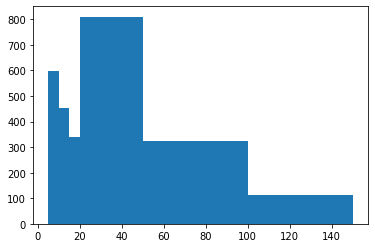

{'min_attempt': 0, 'max_attempt': 265, 'avg_attempt': 28.02340308370044, 'median_attempt': 13.0}
CPU times: user 201 ms, sys: 8.05 ms, total: 209 ms
Wall time: 1.06 s


In [256]:
%%time
attempt_stats = data.aggregate(min_attempt=Min('attempt'), 
                                    max_attempt=Max('attempt'), avg_attempt=Avg('attempt'))
attempts_list = data.values_list("attempt", flat=True)
attempt_stats['median_attempt'] = np.median(attempts_list)

plt.hist(attempts_list, bins=[5,10,15,20,50,100,150])
plt.show()

print(attempt_stats)

Min question attempt: 10
Max question attempt: 304
Min student attempt: 2
Max student attempt: 266


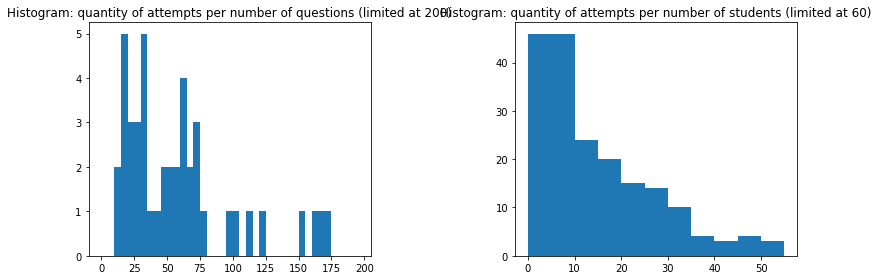

In [302]:
attempts_per_question = defaultdict(int)
attempts_per_student = defaultdict(int)
for row in data:
    s_idx, q_idx, a_idx, outcome = row
    attempts_per_question[q_idx] += 1
    attempts_per_student[s_idx] += 1
    
min_question_attempt = min(attempts_per_question.values())
max_question_attempt = max(attempts_per_question.values())
min_student_attempt = min(attempts_per_student.values())
max_student_attempt = max(attempts_per_student.values())

print("Min question attempt: %d" % min_question_attempt)
print("Max question attempt: %d" % max_question_attempt)
print("Min student attempt: %d" % min_student_attempt)
print("Max student attempt: %d" % max_student_attempt)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
ax1.hist(attempts_per_question.values(), bins=list(range(0,200,5)))
ax1.set_title("Histogram: quantity of attempts per number of questions (limited at 200)")
ax2.hist(attempts_per_student.values(), bins=list(range(0,60,5)))
ax2.set_title("Histogram: quantity of attempts per number of students (limited at 60)")
plt.tight_layout()
plt.show()

Delete student that do not meet minimum number of attempts

In [298]:
MIN_STUDENT_ATTEMPT = 3
MIN_QUESTION_ATTEMPT = 10

In [299]:
del_students = [item[0] for item in attempts_per_student.items() if item[1] < MIN_STUDENT_ATTEMPT]
del_questions = [item[0] for item in attempts_per_question.items() if item[1] < MIN_QUESTION_ATTEMPT]

Splitting in train and test

In [273]:
N_RUNS = 5
TRAIN_PROPORTION = 0.8
TRAIN_ATTEMPTS_TEST = 0.2

In [253]:
def get_user_idx(user_id):
    return users_idx.index(user_id)

def get_question_idx(question_id):
    return questions_idx.index(question_id)

def separate_users_train_and_test(users_idx):
    np.random.shuffle(users_idx)
    idx = int(np.ceil(TRAIN_PROPORTION*len(users)))
    train_users = users_idx[:idx]
    test_users = users_idx[idx:]
    return train_users, test_users

map_user_id = np.vectorize(get_user_idx)    
map_question_id = np.vectorize(get_question_idx)

All attempts

In [301]:
# %%time
users_filtered = users.exclude(user_id__in=del_students)
users_idx = list(users_filtered)

for i in range(N_RUNS):
    train_users, test_users = separate_users_train_and_test(users_idx)
    
    # These users will be uniquely used for train
    train_set = list(data.filter(user_id__in=train_users))
    
    # Some users will be used in training up to a 20% of their attempts
    test_set = []
    # train_attempts = np.random.uniform(size=len(test_users))
    for idx, user in enumerate(test_users):
        user_attempts = data.filter(user_id=user)
        train_attempts = int(np.ceil(TRAIN_ATTEMPTS_TEST*user_attempts.count()))
        train_set.extend(list(user_attempts.filter(attempt__lte=train_attempts).order_by('attempt')))
        test_set.extend(list(user_attempts.filter(attempt__gt=train_attempts).order_by('attempt')))
        
    # Mapping users and questions to be in 0-len index
    train_set = np.asarray(train_set)
    test_set = np.asarray(test_set)
    
    train_set[:,0] = map_user_id(train_set[:,0])
    test_set[:,0] = map_user_id(test_set[:,0])
    
    train_set[:,1] = map_question_id(train_set[:,1])
    test_set[:,1] = map_question_id(test_set[:,1])
    
    dataset = {
        "train_set": train_set,
        "test_set": test_set,
        "concept_idx": concept_idx,
        "questions_idx": questions_idx,
        "users_idx": users_idx,
        "q_matrix": q_matrix,
    }
    
    # Save data
    with open("%s/run_%d.pkl" % (folder, i), "wb") as pklfile:
        pickle.dump(dataset, pklfile)